載入所需函式庫

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torchvision import transforms
import torchvision.models as models
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import matlab.engine as eng



建立 Image Dataset 


In [2]:
class image_dataset(Dataset):
    def __init__(self, matlab_datastore, label_codebook, matlab_session, transform=None):
        self.datasource = matlab_datastore
        self.Matlab_sess = matlab_session
        self.codebook = label_codebook
        self.transform = transform
        
    def __getitem__(self,index):
        
        sess = self.Matlab_sess
        ds = self.datasource
        # if sess.hasdata(ds) and index+1 <= self.__len__():
        # print('getitem:', index)
        img, info = sess.readimage(ds, sess.double(index+1), nargout=2)
        label_name = sess.string(info['Label']) # MATLAB cell string -> python str
        label_encoded = self.codebook[label_name]
        img = Image.fromarray(np.uint8(img[0]))
        if self.transform:
            img = self.transform(img)
            img = np.array(img)
        img = torch.from_numpy(img)

        return img, label_encoded
        

    def __len__(self):
        sess = self.Matlab_sess
        sess.workspace['imds'] = self.datasource
        return len(sess.string(sess.eval('imds.Labels')))
    
    def __class__(self):
        return self.codebook.items()
    
    def reset(self):
        self.Matlab_sess.reset(self.datasource, nargout=0)

class imgClassfier(nn.Module):
    def __init__(self, num_classes=3, dropout = 0.5):
        super().__init__()
        self.avgpool = nn.AdaptiveAvgPool2d((7,7))
        self.classifier = nn.Sequential(
            nn.Linear(100 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 3),
        )
    def forward(self, x):
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x



In [13]:
# Helper Function
def set_parameter_requires_grad(model, featureExtracting):
    if featureExtracting:
        for param in model.parameters():
            param.requires_grad = False
            
def Resnet_pretrained_model(numClasses, featureExtract=True, usePretrained=True):
    model = models.resnet18(pretrained=usePretrained)
    set_parameter_requires_grad(model, featureExtract)
    numFtrs = model.fc.in_features
    model.fc = nn.Linear(numFtrs, numClasses)
    return model

def train(net, dataloader, optimizer, criterion, epochs, device):
    net.train()
    net.to(device)
    accuracy = 0
    total_loss = 0
    for epoch in range(epochs):
        for x, label in dataloader:
            x = x.to(device, dtype=torch.float)
            label = label.to(device, dtype=torch.long)
            optimizer.zero_grad()
            output = net(x)
            # 預留位置01
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()

            total_loss += loss
            total_loss /= len(dataloader.dataset)
        if epoch%10==0:
            print('[{}/{}] Loss:'.format(epoch+1, epochs),total_loss.item())
    return net

In [4]:
sess = eng.start_matlab()


In [5]:

# Image Data Path
img_path = 'C:/Users/Tim/Desktop/GitHub Project/Practice Project/Week1-Dog Image Classification/Dataset/Dog_Images'
imds = sess.imageDatastore(img_path,
    'IncludeSubfolders',True,
    'LabelSource','foldernames')
sess.workspace['imds'] = imds
labels = sess.eval('imds.Labels')
gname, counts = sess.grpstats(labels,
    labels,
    ['gname','numel'], nargout=2)

# Create encoding for data label
label_codebook = dict(zip(gname,list(range(0,len(gname)))))
print(label_codebook.items())

dict_items([('Chihuahua', 0), ('Japanese_spaniel', 1), ('Maltese_dog', 2)])


<BarContainer object of 3 artists>

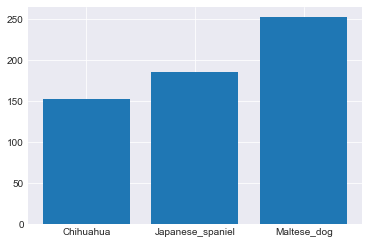

In [6]:
# Change Plot Color Style for Jupyter Notebook Dark Theme
style.use('seaborn-darkgrid')
plt.figure()
plt.bar(gname, list(counts._data))


In [7]:
# Split to training and testing dataset with same percentage of label
trainImds, testImds = sess.splitEachLabel(imds,0.7,nargout=2)
sess.workspace['trainImds'] = trainImds
sess.workspace['testImds'] = testImds
print('Training Size:', len(sess.eval('trainImds.Files')))
print('Testig Size:', len(sess.eval('testImds.Files')))


Training Size: 412
Testig Size: 177


In [14]:


dataset = image_dataset(trainImds, label_codebook, sess,
transform = transforms.Resize([224,224]))
dataset.reset()

dataloader = DataLoader(dataset, 
    batch_size=32,
    shuffle=True)

epochs = 300
batch_size = 8
learningRate = 0.001
use_cuda = 1
loss_function  = nn.CrossEntropyLoss()
training_device = torch.device(
    # 如果有GPU可以使用，則選擇使用GPU
    "cuda" if (torch.cuda.is_available() & use_cuda)
    else "cpu")


mdl = Resnet_pretrained_model(3)
optimizer = torch.optim.Adam(mdl.parameters(),lr=learningRate)
trained_mdl = train(mdl,dataloader,optimizer,loss_function,epochs,training_device)
  

RuntimeError: Given groups=1, weight of size [64, 3, 7, 7], expected input[32, 224, 224, 3] to have 3 channels, but got 224 channels instead